# Logistic Regression Credit Risk Model Pipeline

1.  Logistic Regression Model

2.  Logistic Regression Model Performance:
-   **ROC_AUC**
-   **Balanced Accuracy** (Balanced Accuracy= 0.5 * (Sensitivity + Specificity))
-   **Confusion Matrix** (Precision Recall)
-   **Log Loss**

2.  Logistic Regression Model Calibration 
-   **Venn-Abers (cross and inductive)**
-   **Isotonic Regression**
-   **Platts Scaling**


3.  Logistic Regression Model Calibration Performance:
-   **Log Loss**
-   **Brier Score**
-   **Expected Calibration Error** (Plot for this as well)
-   **Calibration Curve**


Please also save predictions/probabilities, target (loan status) and ID for each set (we will need it the final step)
 

## 1. **Data Loading**
- Load preprocessed datasets:
  - `train` → used to fit the model  
  - `validation` → used to tune & evaluate  
  - `test` → final unbiased evaluation  

In [132]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


# Read CSV file
df_test = pd.read_csv("DATA/preprocessed_test.csv")
df_train = pd.read_csv("DATA/preprocessed_train.csv")
df_valid = pd.read_csv("DATA/preprocessed_valid.csv")

# Show first 5 rows
# print(df_train.head())

## 2. **Splitting Features and Labels**
- Features: all columns except **`loan_status`** (target) and **`ID`** (non-predictive).  
- Labels: `loan_status` (default = 1, no default = 0).  

In [133]:
# Features (exclude target and ID)
X_train = df_train.drop(columns=["loan_status", "ID"])
y_train = df_train["loan_status"]

X_valid = df_valid.drop(columns=["loan_status", "ID"])
y_valid = df_valid["loan_status"]

X_test  = df_test.drop(columns=["loan_status", "ID"])
y_test  = df_test["loan_status"]


## 3. **Feature Scaling**
- Standardize features (mean=0, std=1) using **`StandardScaler`**.  
- **Fit on training data** → apply same scaling to validation and test.   

In [134]:
# Scale features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

## 4. **Model Training, Validation & Test Predictions**
- Logistic Regression with `max_iter=1000` and solver `"lbfgs"`.

In [135]:
# Build logistic regression model
model = LogisticRegression(max_iter=1000, solver="lbfgs")

# Train
model.fit(X_train, y_train)

# Validate
y_pred_valid = model.predict(X_valid)
print("\nValidation Accuracy:", round(accuracy_score(y_valid, y_pred_valid),4))

# Test
y_pred_test = model.predict(X_test)
print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred_test),4))



Validation Accuracy: 0.8564

Test Accuracy: 0.8478


## 5. **Evaluate model performance on validation & test sets**

- Compute metrics: ROC AUC, Balanced Accuracy, Precision, Recall, Log Loss
- Plot confusion matrices and derive Sensitivity & Specificity


 Model Performance Validation and Test set:


,Validation,Test
ROC AUC,0.8679,0.8582
Balanced Accuracy,0.7336,0.7155
Precision,0.7297,0.7270
Recall (Sensitivity),0.5194,0.4812
Specificity,0.9478,0.9497
Log Loss,0.3445,0.3570
Balanced Accuracy,0.7336,0.7155


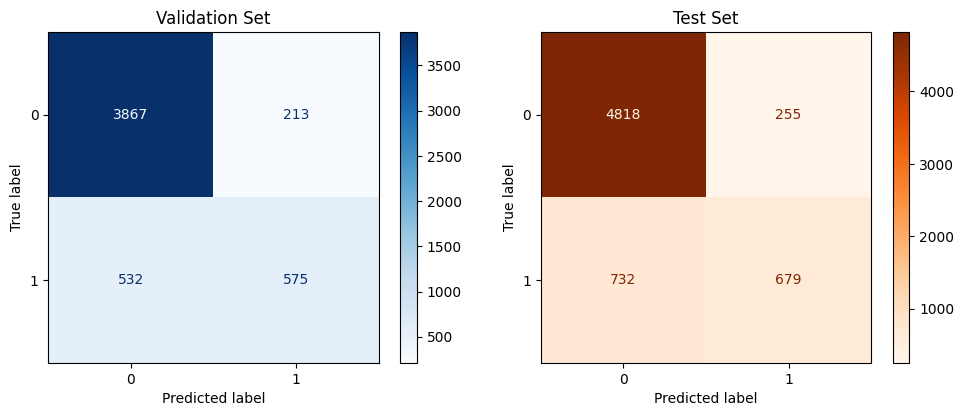

In [136]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- VALIDATION METRICS ---
y_proba_valid = model.predict_proba(X_valid)[:, 1]
roc_auc_valid = roc_auc_score(y_valid, y_proba_valid)
balanced_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
precision_valid = precision_score(y_valid, y_pred_valid)
recall_valid = recall_score(y_valid, y_pred_valid)
logloss_valid = log_loss(y_valid, y_proba_valid)

tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_valid).ravel()
sensitivity_valid = tp / (tp + fn)
specificity_valid = tn / (tn + fp)
balanced_acc_manual_valid = 0.5 * (sensitivity_valid + specificity_valid)

# --- TEST METRICS ---
y_proba_test = model.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_proba_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
logloss_test = log_loss(y_test, y_proba_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)
balanced_acc_manual_test = 0.5 * (sensitivity_test + specificity_test)

# --- Put results in a DataFrame for nice visualization ---
metrics_df = pd.DataFrame({
    "Validation": [
        roc_auc_valid, balanced_acc_valid, precision_valid, recall_valid, 
        specificity_valid, logloss_valid, balanced_acc_manual_valid
    ],
    "Test": [
        roc_auc_test, balanced_acc_test, precision_test, recall_test,
        specificity_test, logloss_test,  balanced_acc_manual_test
    ]
}, index=[
    "ROC AUC",
    "Balanced Accuracy",
    "Precision",
    "Recall (Sensitivity)",
    "Specificity",
    "Log Loss",
    "Balanced Accuracy"
])

# Round to 4 decimals for readability
metrics_df = metrics_df.round(4)

print("\n Model Performance Validation and Test set:")
display(metrics_df)

# --- Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Set")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=axes[1], cmap="Oranges")
axes[1].set_title("Test Set")
plt.tight_layout()
plt.show()


### **Overall analysis**
#### **Strengths**:
-   High ROC AUC → good ranking ability.
-   High specificity → model reliably identifies negatives.
-   Precision is decent → when it predicts positive, it’s usually correct.
#### **Weaknesses**:
-   Recall is low → model misses many positives.
-   Slight drop in all metrics on test → minor overfitting.
#### **Likely cause of imbalance in recall vs. specificity**:
-   Probably class imbalance, or the decision threshold (default 0.5) favors the majority class.

## 6. **Calibration Step: Venn-Abers, Platt Scaling & Isotonic Regression**
The goal of this code is to improve the probabilistic calibration of the Logistic Regression model. While the raw model outputs probabilities, these are not always well-calibrated (e.g., a score of 0.8 does not always correspond to an 80% chance of default).
- **`Platt Scaling`** (sigmoid): Fits a logistic (sigmoid) function on top of the raw scores. 
- **`Isotonic Regression`**: A non-parametric method that fits a piecewise-constant function. 
- **`Venn-Abers`**: 

We evaluate calibration quality using:
- **`Log Loss`** → Measures the penalty of miscalibrated probabilities.
- **`Brier Score`** → Mean squared error between predicted probabilities and actual outcomes.
- **`Expected Calibration Error`** (ECE): Quantifies how close predicted probabilities are to observed frequencies.
- **`Calibration Curves`**: Visual comparison between predicted probability vs actual outcomes.
Finally, calibrated probabilities are saved alongside raw outputs for reporting and downstream use.

In [ ]:
from venn_abers import VennAbersCalibrator
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# --- Fit calibration models on validation set (model already trained) ---
platt = CalibratedClassifierCV(estimator=model, method="sigmoid", cv="prefit")
platt.fit(X_valid, y_valid)

isotonic = CalibratedClassifierCV(estimator=model, method="isotonic", cv="prefit")
isotonic.fit(X_valid, y_valid)

va_inductive = VennAbersCalibrator(estimator=model, inductive=True, cal_size=None, random_state=42)
va_inductive.fit(X_valid, y_valid)


p_cal = model.predict_proba(X_valid)
p_test = model.predict_proba(X_test)

VAC = VennAbersCalibrator()
predictions_IVAP, intervals = VAC.predict_proba(p_cal=p_cal, y_cal=y_valid.values, p_test=p_test, p0_p1_output=True)

#3 cols: calibrated prob, p0 and p1

model = LogisticRegression(max_iter=100, solver="lbfgs")

va_cross = VennAbersCalibrator(
    estimator=model,  
    inductive=False,
    n_splits=5,          
    random_state=42
)
va_cross.fit(X_valid, y_valid) #combine train and valid 

p_va_cross, p_va_cross_p0_p1 = va_cross.predict_proba(X_test, p0_p1_output=True)

#5 columns: calibrated prob, mean of the 5 p0's, mean of 5 p1's add 2 cols; min(p0) and max(p1)


# --- Predict calibrated probabilities on TEST set ---
proba_raw = model.predict_proba(X_test)[:, 1]
proba_platt = platt.predict_proba(X_test)[:, 1]
proba_iso = isotonic.predict_proba(X_test)[:, 1]
proba_va_ind= predictions_IVAP[:, 1]

# 2 files for validation and for test set with these cols:
#id , row prob (model outpu, prob of class 1), isotonic prob calib, platt scaling calib prob, inductive ven abb, p0,p1, cross ven abb cal prob, p0mean, p1mean, minp0, maxp1


In [231]:
print(p_va_cross)

[[0.96478849 0.03521151]
 [0.11723307 0.88276693]
 [0.76359163 0.23640837]
 ...
 [0.87872139 0.12127861]
 [0.69504053 0.30495947]
 [0.87992718 0.12007282]]


In [233]:
print(p_va_cross_p0_p1)
print(p_va_cross_p0_p1[0])

[array([[0.03296703, 0.02380952, 0.        , ..., 0.03703704, 0.01948052,
        0.04140127],
       [0.85714286, 0.88888889, 0.78571429, ..., 0.85714286, 1.        ,
        0.95652174],
       [0.19685039, 0.21875   , 0.21621622, ..., 0.24324324, 0.25641026,
        0.20253165],
       ...,
       [0.14594595, 0.11764706, 0.1292517 , ..., 0.13605442, 0.08510638,
        0.11940299],
       [0.19685039, 0.38095238, 0.31818182, ..., 0.34090909, 0.33333333,
        0.29166667],
       [0.14594595, 0.07692308, 0.1292517 , ..., 0.13605442, 0.08510638,
        0.11940299]])]
[[0.03296703 0.02380952 0.         ... 0.03703704 0.01948052 0.04140127]
 [0.85714286 0.88888889 0.78571429 ... 0.85714286 1.         0.95652174]
 [0.19685039 0.21875    0.21621622 ... 0.24324324 0.25641026 0.20253165]
 ...
 [0.14594595 0.11764706 0.1292517  ... 0.13605442 0.08510638 0.11940299]
 [0.19685039 0.38095238 0.31818182 ... 0.34090909 0.33333333 0.29166667]
 [0.14594595 0.07692308 0.1292517  ... 0.13605442 0

In [239]:
print(p_va_cross_p0_p1[0][0])
print(p_va_cross_p0_p1[0][1])
print(p_va_cross_p0_p1[0][2])

p_va_cross_p0_p1[0].shape

[0.03296703 0.02380952 0.         0.         0.03821656 0.04395604
 0.04477612 0.03703704 0.01948052 0.04140127]
[0.85714286 0.88888889 0.78571429 0.9        0.90909091 0.91304348
 1.         0.85714286 1.         0.95652174]
[0.19685039 0.21875    0.21621622 0.23333333 0.18987342 0.20634921
 0.33333333 0.24324324 0.25641026 0.20253165]


(6484, 10)


Calibration Performance (Test Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.3570,0.1089,0.0291
Platt Scaling,0.3575,0.1088,0.0303
Isotonic Regression,0.3852,0.1090,0.0244
Venn-Abers (Inductive),0.3559,0.1089,0.0291


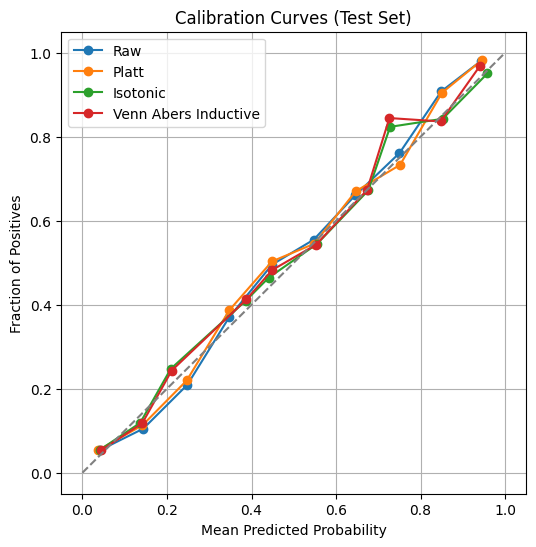

In [214]:
# --- Calibration metrics function (return metrics instead of only printing) ---
def calibration_metrics(y_true, y_proba, method_name):
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)
    ece = np.abs(prob_true - prob_pred).mean()
    
    return {
        "Method": method_name,
        "Log Loss": logloss,
        "Brier Score": brier,
        "ECE": ece
    }

# --- Collect results into a list ---
results = []
results.append(calibration_metrics(y_test, proba_raw,   "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_test, proba_platt, "Platt Scaling"))
results.append(calibration_metrics(y_test, proba_iso,   "Isotonic Regression"))
results.append(calibration_metrics(y_test, proba_va_ind,       "Venn-Abers (Inductive)"))
#results.append(calibration_metrics(y_test, proba_cross_va,     "Venn-Abers (Cross)"))

# --- Convert to DataFrame for comparison ---
calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Test Set):")
display(calib_df)

# --- Plot calibration curves all together ---
plt.figure(figsize=(6, 6))
for proba, name in [
    (proba_raw, "Raw"),
    (proba_platt, "Platt"),
    (proba_iso, "Isotonic"),
    (proba_va_ind, "Venn Abers Inductive"),
    #(proba_cross_va, "Venn Abers Cross"),
]:
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


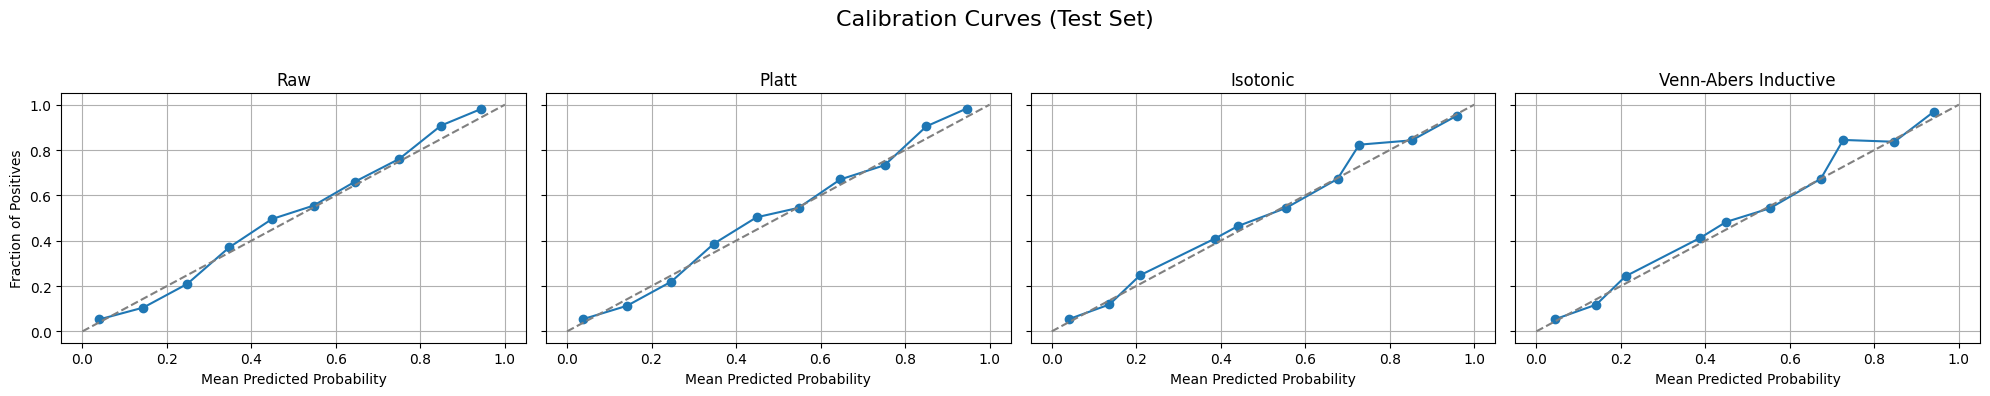

In [227]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- List of predictions and names ---
probas = [
    (proba_raw, "Raw"),
    (proba_platt, "Platt"),
    (proba_iso, "Isotonic"),
    (proba_va_ind, "Venn-Abers Inductive"),
    #(proba_cross_va, "Venn-Abers Cross"),
]

# --- Create subplots side by side ---
fig, axes = plt.subplots(1, len(probas), figsize=(20, 4), sharey=True)

for ax, (proba, name) in zip(axes, probas):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=name)
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_title(name)
    ax.grid(True)

axes[0].set_ylabel("Fraction of Positives")
plt.suptitle("Calibration Curves (Test Set)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Raw logistic regression is already well-calibrated...
ECE is very low (0.029), Brier score is good, log loss is reasonable.
Calibration methods did not improve anything; some even worsened log loss significantly...
For this model it seems that, we don’t need calibration.We can use the raw predicted probabilities.

In [228]:
# --- Save all predictions and scores for final report ---
df_output = pd.DataFrame({
    "ID": df_test["ID"],
    "loan_status": y_test,
    "raw_score": proba_raw,
    "platt_score": proba_platt,
    "isotonic_score": proba_iso,
    "venn_abers_ind_": proba_va_ind,
    #"venn_abers_cross_score": proba_cross_va,
    #"venn_abers_ind_lower": p_va_cross_lower, 
    #"venn_abers_ind_upper":p_va_cross_upper, 

})

df_output.to_csv("/Users/elisaterzini/Desktop/Credit-Risk-Model-Calibration/DATA/final_predictions_and_calibration.csv", index=False)
print("Saved predictions to 'final_predictions_and_calibration.csv'")


Saved predictions to 'final_predictions_and_calibration.csv'


In [76]:
print(df_output.head())

      ID  loan_status  raw_score  platt_score  isotonic_score   
0  20441            0   0.020382     0.016780        0.023121  \
1   1091            1   0.874018     0.883839        0.939394   
2   4763            0   0.273264     0.262787        0.208617   
3  12382            0   0.609563     0.613783        0.672986   
4  15113            0   0.011773     0.009414        0.016393   

   venn_abers_ind_score  venn_abers_cross_score  
0              0.039604                0.035212  
1              0.907950                0.882767  
2              0.201893                0.236408  
3              0.699474                0.655847  
4              0.025974                0.018959  


-   **`loan_status`**
The true label:
0 → not default
1 → default
-   **`raw_score`**
The model’s raw predicted probability of default before calibration.
Example:
ID 20441 → 0.020382 → very low predicted probability of default → correct because loan_status = 0.
ID 1091 → 0.874018 → high predicted probability of default → correct because loan_status = 1.